# Interactive study

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import mpld3
from observation import Observation
from constants import *

plt.style.use('ggplot')
#mpld3.enable_notebook()

reactor_site = "A1" #[site+tranche for site in ["A","B","C","D","E","F","G","H"] for tranche in ["1","2"]] + ["B3","B4","F3","F4"]

suffixes = [
"DEB1-1","DEB1-2"#,"DEB1-3","DEB1-4", # Débit de fuite au joint 1 (Gamme Large)
#"DEB2-1","DEB2-2","DEB2-3","DEB2-4", # Débit de fuite au joint 1 (Gamme Étroite)
#"DEB3-1","DEB3-2","DEB3-3","DEB3-4","DEB3-5", # Débit d'injection au joint
#"PUI-",  # Puissance thermique moyenne
#"PRE-",  # Pression
#"TEM1-", # Température ligne d'injection aux joints (en * Celsius) ### A rapprocher de DEB3
#"TEM2-", # Température fuites joint 1
#"TEM3-1","TEM3-2","TEM3-3","TEM3-4",# Température eau joint 1 - 051PO ### A rapprocher de DEB1 DEB2
#"VIT-1","VIT-2","VIT-3","VIT-4"# Vitesse de rotation
] 

PATH = "../../Data/GMPP_IRSDI/"
obs = Observation(PATH,reactor_site,suffixes,verbose=1,ignore_keys=deb2)
intervals = obs.split_between()

print(str(len(obs.df))+" : Initial length of full df")
print(str(np.sum([len(df) for df in intervals]))+" : New length of all selected intervals")

Loading in memory 2 observations...
Concatenation...
Changing isolated wrong values...
Forward Filling...
Backward Filling...
525887 : Initial length of full df
522689 : New length of all selected intervals


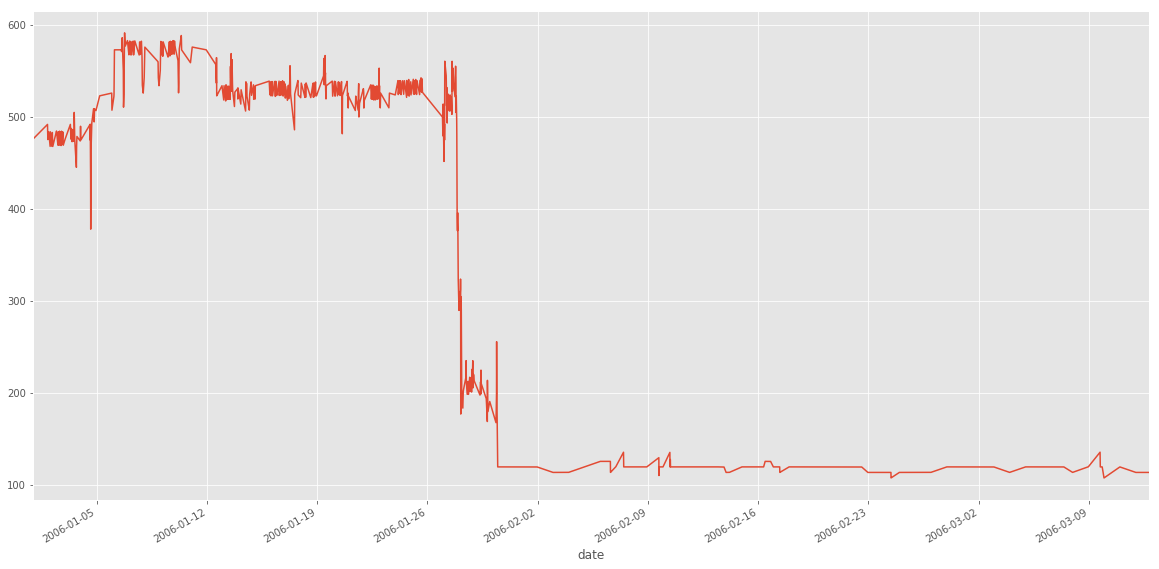

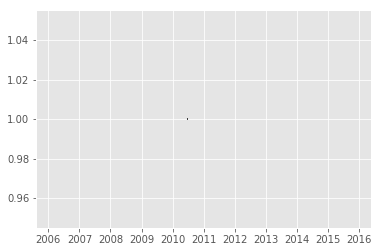

In [15]:
df = obs.full_concatenated_df
df1 = df[deb1[0]]#[0:10000].copy()
df[deb1[0]][].plot(figsize = (20,10))
obs.intervals_to_remove.plot()


In [16]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

def find_trans(df,w_length,rate):
    result = []
    mean_tot = np.mean(df)
    first_index = 0
    current_pos = first_index + w_length
    max_tot = np.max(df)
    min_tot = np.min(df)
    subpart = (max_tot - min_tot)/rate
    submean = np.mean(df.iloc[first_index:current_pos].values)
    previous_mean = submean
    while (current_pos < len(df) - w_length):
        submean = np.mean(df.iloc[(current_pos-w_length):current_pos].values)
        if (math.fabs(submean - previous_mean) < subpart):
            current_pos = current_pos + w_length
            previous_mean = np.mean(df.iloc[first_index:current_pos].values)
        else:
            result.append((first_index,current_pos))
            first_index = current_pos
            current_pos = current_pos + w_length
            previous_mean = submean
    if (first_index != current_pos):
        result.append((first_index,current_pos))
    if (current_pos < len(df) - 1):
        result.append((current_pos, len(df) - 1))
    return result


def compute_mean_size(categories):
    result = 0
    for i in range(len(categories)):
        result = result + (categories[i][1] - categories[i][0])
    return (int)(result/len(categories))


def interval_to_aggregate(df, categories):
    result = []
    for i in range(len(categories)):
        rate = ((math.fabs(df.iloc[categories[i][1]] - df.iloc[categories[i][0]]))/(categories[i][1] - categories[i][0]))
        #print(rate)
        #print((np.max(df) - np.min(df))/len(df) * 50)
        if (rate > (np.max(df) - np.min(df))/len(df) * 5):
            result.append(categories[i])
    return result

def aggregate(df, categories):
    
    first_pos = 0
    current_pos = categories[0][0]
    result = []
    index = 0
    if (current_pos != first_pos):
        result.append((first_pos,current_pos))
    first_pos = categories[0][0]
    current_pos = categories[0][1]
    while (index < len(categories) - 1):
        if not(current_pos == categories[index+1][0]):
            result.append((first_pos,current_pos))
            result.append((current_pos,categories[index+1][0]))
            first_pos = categories[index+1][0] 
        current_pos = categories[index+1][1] 
        index += 1
    
    if (first_pos != categories[index][0]): 
        result.append((first_pos,current_pos))
    if (current_pos < len(df) - 1):
        result.append((current_pos,len(df) - 1))
    return result



def segment_data(df,w_length,rate):
    print("finding transitoire subsection...")
    result = find_trans(df,w_length,rate)
    print("transitoire subsection found, len of the categories :")
    print(len(result))
    print("select intervals to aggregate...")
    to_remove = interval_to_aggregate(df,result)
    print("intervals to aggregate selecte. Number of intervals :")
    print(len(to_remove))
    print("aggregate intervals...")
    #result = aggregate(df, to_remove)
    print("intervals aggregrated, result returned, final number of categories :")
    result = find_high_transition(df,result)
    #remove_high_trans(df,result,obs)
    print(len(result))
    return result
        
        
        
        
# print categories with the following format:
# categories = ( [ (start_point, end_point), ...  ],   first cat
#                [ (start_point, end_point), ...  ],   second cat
#                [ (start_point, end_point), ...  ] )  last cat
def printCat(df, categories):
    #ax = df.plot(figsize = (20,10))
    df.resample('1D',label='right').median().plot(figsize=(20,10))
    for i in range(len(categories)):
        toPrint = select_from_to(df,categories[i][0],categories[i][1])
        toPrint.resample('1D',label='right').median().plot(figsize=(20,10),color='black')
        
# print categories with the following format:
# categories = [ (start_point, end_point, category_nbr), ...  ]
def print_select_cat(df,nbr, categories):
    for i in range(len(categories)):
        if (categories[i][2] == nbr):
            toPrint = select_from_to(df,categories[i][0],categories[i][1])
            toPrint.plot(figsize=(20,10))
            

def merge_interval(int1,int2):
    if (int1[1] >= int2[0]):
        return True
    else:
        return False

            
def find_high_transition(df,categories):
    result = []
    margin = 1000
    index = 0
    for i in range(len(categories) - 1):
        result.append((max(0,(categories[i][1] - margin)),min(len(df) - 1, categories[i+1][0] + margin)))
    while (index < len(result)-1):
        if (merge_interval(result[index],result[index+1])):
            interval = (result[index][0],result[index+1][1])
            result.remove((result[index][0],result[index][1]))
        else:
            index += 1
    return result

def remove_high_trans(df,categories,obs):
    low_values = obs.low_regime_intervals.intervals
    for i in range(len(low_values)):
        for j in range(len(categories)):
            if (merge_interval(categories[j], low_values[i])):
                categories.append((categories[j][0], low_values[i][0]))
                categories.remove((categories[j][0], categories[j][1]))
            elif (merge_interval(low_values[i],categories[j])):
                result.append((low_values[i][1], categories[j][1]))
                categories.remove((categories[j][0], categories[j][1]))
                
def select_from_to(data, startIndex, endIndex):
    try:
        sub_part = data.iloc[startIndex:endIndex]
        new_data = sub_part.copy()
        return new_data
    except:
        print("index out of range, or negative size")
                
            

522689
finding transitoire subsection...
transitoire subsection found, len of the categories :
22
select intervals to aggregate...
intervals to aggregate selecte. Number of intervals :
14
aggregate intervals...
intervals aggregrated, result returned, final number of categories :
17
[(2952, 4952), (9712, 11712), (76272, 78272), (82564, 84564), (139452, 141452), (151256, 153256), (220884, 222884), (228944, 230944), (236796, 238796), (297896, 299896), (308608, 310608), (381876, 383876), (388012, 390012), (445680, 447680), (456184, 458184), (460292, 462292), (521652, 522688)]
398.255580359


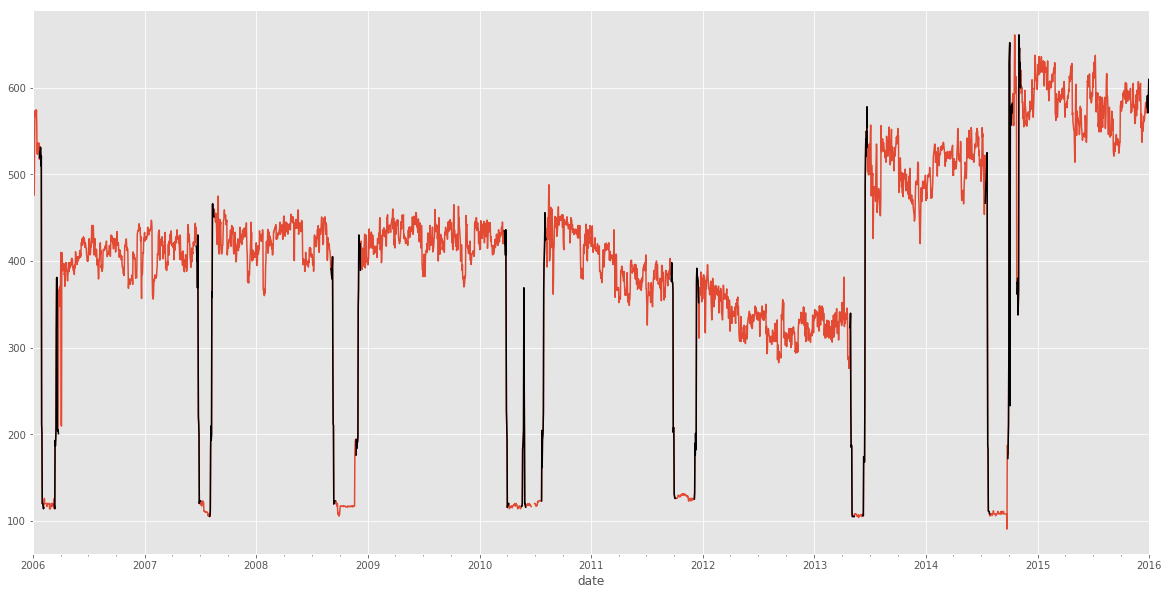

In [17]:
print(len(df1))
test = segment_data(df1,(int)(len(df1)/10000),5)
print(test)
printCat(df1,test)
print(np.mean(df1))


### Filtering and simple sorting ideas

In [ ]:
roll_var = lambda df: df[deb1].rolling(20).var().max(axis=0).max()
power_above_80 = lambda df: ((df[pui]<80).sum()==0).any()
jump = lambda df: df[deb1].diff().max().max()

### Trend detection

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

def max_overall_slope(df):
    reg = LinearRegression()
    df = df[deb1]
    reg.fit(np.arange(len(df)).reshape(len(df),-1),df.values)
    return reg.coef_.max()*len(df)

def min_overall_slope(df):
    reg = LinearRegression()
    df = df[deb1]
    reg.fit(np.arange(len(df)).reshape(len(df),-1),df.values)
    return -reg.coef_.min()*len(df)

w_length = 30
def max_rolling_slope(df):
    reg = LinearRegression()
    df = df[deb1]
    l_reg = []
    for i in range(len(df)-w_length):
        fit = reg.fit(np.arange(w_length).reshape(w_length,-1), df.iloc[i:i+w_length].values) 
        l_reg += [(fit.coef_.max(),fit.coef_.argmax(),i)]
    return max(l_reg,key=lambda x: x[0])[0]

def min_rolling_slope(df):
    reg = LinearRegression()
    df = df[deb1]
    l_reg = []
    for i in range(len(df)-w_length):
        fit = reg.fit(np.arange(w_length).reshape(w_length,-1), df.iloc[i:i+w_length].values) 
        l_reg += [(fit.coef_.min(),fit.coef_.argmin(),i)]
    return -min(l_reg,key=lambda x: x[0])[0]

### Oscillation detection

In [ ]:
w_1 = 3; w_2 = 40
osc_filter = lambda df: len(df[deb1[:2]])>w_1+w_2
osc_var = lambda df: df[deb1[:2]].rolling(w_1).var().rolling(w_2).median().max(axis=0).max()

### Fourier ideas

In [ ]:
from cmath import *

strong_fourier_component = lambda df: np.max(np.abs(np.fft.fft(df[deb1],axis=0))[1:])
mean_fourier_component = lambda df: np.mean(np.abs(np.fft.fft(df[deb1],axis=0))[1:])
median_fourier_component = lambda df: np.median(np.abs(np.fft.fft(df[deb1],axis=0))[1:])

w_fourier = 100
fourier_filter = lambda df: len(df[deb1])>w_fourier
def rolling_fourier(df):
    df = df[deb1]
    current_fft = np.fft.fft(df.iloc[:w_fourier].values,axis=0)
    current_max = np.max(np.abs(current_fft)[2:int(w_fourier/2)])
    arange_op = np.exp(2j*pi*np.arange(w_fourier).reshape(-1,1)/w_fourier)
    for i in range(len(df)-w_fourier):
        current_fft = (current_fft - df.iloc[i].values + df.iloc[w_fourier+i].values)*arange_op
        current_max = max(current_max, np.max(np.abs(current_fft)[2:int(w_fourier/2)]))
    return current_max

### Interaction

In [ ]:
from interaction import Interaction

interaction = Interaction(intervals)
# interaction.add_idx("Rolling variance",roll_var)
# interaction.add_filter("Power above 80",power_above_80)
# interaction.add_idx("Jump",jump)

#interaction.add_idx("Increasing trend",max_overall_slope)
#interaction.add_idx("Decreasing trend",min_overall_slope)

#interaction.add_idx("Oscillation (var)",osc_var,osc_filter)
# interaction.add_idx("Oscillation (fourier)",rolling_fourier,fourier_filter)
#interaction.add_idx("Mean Fourier Component",mean_fourier_component)
#interaction.add_idx("Strong Fourier Component",strong_fourier_component)
#interaction.add_idx("Median Fourier Component",median_fourier_component)